In [38]:
import sys
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import (
    ViTFeatureExtractor,
    ViTModel,
    SegformerFeatureExtractor,
    SegformerModel,
)
from torch.utils.data import random_split, BatchSampler, SequentialSampler
import torch
import torchvision
import os
import shutil
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import verify_str_arg
from torchvision.datasets.utils import download_and_extract_archive
from tqdm import tqdm

from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance, chi2
from ot import (
    sliced_wasserstein_distance,
    gromov_wasserstein,
    sinkhorn2,
    gromov_wasserstein2,
)
from numpy import linalg as LA
from sklearn.metrics.pairwise import euclidean_distances
from multiprocessing import Pool, Process
import time
import itertools


home_dir = '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset'
sys.path.insert(0, home_dir)
sys.path.insert(0, home_dir + "/cords")

seed = 42
device = 'cuda'
data_dir = '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/data/preprocessing'


In [11]:
def load_embeddings(pickle_name):
    """
    Load embeddings from disc
    """
    with open(pickle_name, "rb") as fIn:
        stored_data = pickle.load(fIn)
        # stored_sentences = stored_data['sentences']
        stored_embeddings = stored_data["embeddings"]
    return stored_embeddings

In [12]:
def store_embeddings(pickle_name, embeddings):
    """
    Store embeddings to disc
    """
    with open(pickle_name, "wb") as fOut:
        pickle.dump({"embeddings": embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
def compute_vit_image_embeddings(images, device, return_tensor=False):
    feature_extractor = ViTFeatureExtractor.from_pretrained(
        "google/vit-large-patch16-224-in21k"
    )
    model = ViTModel.from_pretrained("google/vit-large-patch16-224-in21k")
    model = model.to(device)
    # inputs = feature_extractor(images, return_tensors="pt")
    sampler = BatchSampler(SequentialSampler(range(len(images))), 20, drop_last=False)

    inputs = []
    for indices in tqdm(sampler, total=len(sampler), desc='pre-processing'):
        if images[0].mode == "L":
            images_batch = [images[x].convert("RGB") for x in indices]
        else:
            images_batch = [images[x] for x in indices]
        inputs.append(feature_extractor(images_batch, return_tensors="pt"))

    img_features = []
    for batch_inputs in tqdm(inputs, total=len(batch_inputs), desc='embedding'):
        tmp_feat_dict = {}
        for key in batch_inputs.keys():
            tmp_feat_dict[key] = batch_inputs[key].to(device=device)
        with torch.no_grad():
            batch_outputs = model(**tmp_feat_dict)
        batch_img_features = batch_outputs.last_hidden_state.mean(
            dim=1
        ).cpu()  # Averages over channels
        img_features.append(batch_img_features)
        del tmp_feat_dict

    img_features = torch.cat(img_features, dim=0)
    if return_tensor == False:
        return img_features.numpy()
    else:
        return img_features

In [14]:
def plot_singular_vals(embeddings, title, use_covariance = True):
    if len(embeddings.shape) == 3:
        embeddings = embeddings.reshape((embeddings.shape[0], embeddings.shape[1]**2))
    if use_covariance == True:
        cov = np.cov(embeddings, rowvar=False)
        U, s, V = np.linalg.svd(cov)
    else:
        U, s, V = np.linalg.svd(embeddings)
    plt = sns.scatterplot(np.log(s))
    plt.set_title(title)
    plt.set_xlabel('Singular Value Rank Index')
    plt.set_ylabel('Log of Singular Value')

In [15]:
def get_cdist_2D(matrix):
    d = matrix.shape[0]
    cdist = np.zeros((d, d))
    for i in tqdm(range(d), total=d, desc="generating cdist 2D matrix"):
        for j in range(d):
            cdist[i][j] = LA.norm(matrix[i] - matrix[j], ord=2)
    return cdist


def get_sliced_wasserstein_dist(params):
    i, j = params
    return (i, j), sliced_wasserstein_distance(
        emb[i] / np.max(emb[i]), emb[j] / np.max(emb[j]), n_projections=100
    )


def get_gromov_wasserstein_dist(params):
    i, j = params
    dist = abs(gromov_wasserstein2(emb[i] / np.max(emb[i]), emb[j] / np.max(emb[j])))
    return (i, j), dist


def get_fronerbius_dist(params):
    i, j = params
    dist = LA.norm(emb[i] - emb[j], ord="fro")
    return (i, j), dist


def get_mmd_dist(params):
    i, j = params
    dist = mmd_rbf(emb[i] / np.max(emb[i]), emb[j] / np.max(emb[j]), gamma=gamma)
    return (i, j), dist


def mmd_rbf(X, Y, gamma=1.0):
    """
    ala: https://github.com/jindongwang/transferlearning/blob/master/code/distance/mmd_numpy_sklearn.py

    NOTE:
        - define gamma according to suggestion in: https://torchdrift.org/notebooks/note_on_mmd.html

    MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()


WASSERSTEIN_METHOD_DICT = {
    "sliced_wasserstein": get_sliced_wasserstein_dist,
    "gromov_wasserstein": get_gromov_wasserstein_dist,
}

def get_cdist(V):
    ct = time.time()
    dist_mat = euclidean_distances(V)
    print("Distance Matrix construction time ", time.time() - ct)
    return get_square(dist_mat)

def get_square(mat):
    return mat**2

def get_rbf_kernel(dist_mat, kw=0.1):
    sim = np.exp(-dist_mat / (kw * dist_mat.mean()))
    return sim


# @jit(nopython=True, parallel=True)
def get_dot_product(mat):
    sim = np.matmul(mat, np.transpose(mat))
    return sim


def get_wasserstein(mat, n_projections=1000, method="sliced"):
    assert len(mat.shape) == 3, "embeddings are not 2D for wasserstein"

    global n
    global sim
    global emb

    n = int(mat.shape[0])
    sim = np.zeros((n, n))
    emb = mat

    n_processors = 8

    i = range(n)
    j = range(n)

    paramlist = list(itertools.product(i, j))

    pool = Pool(maxtasksperchild=100, processes=n_processors)

    similarities = {}

    func = WASSERSTEIN_METHOD_DICT[method]
    for k, v in tqdm(
        pool.imap_unordered(func, paramlist, chunksize=10000),
        total=len(paramlist),
    ):
        similarities[k] = v

    for k in similarities.keys():
        i, j = k
        sim[i][j] = similarities[k]

    sim = sim / np.max(sim)  # normalise

    return sim


def get_fronerbius(mat):
    assert len(mat.shape) == 3, "embeddings are not 2D for wasserstein"

    global n
    global sim
    global emb

    n = int(mat.shape[0])
    sim = np.zeros((n, n))
    emb = mat

    n_processors = 8

    i = range(n)
    j = range(n)

    paramlist = list(itertools.product(i, j))

    pool = Pool(maxtasksperchild=100, processes=n_processors)

    similarities = {}

    for k, v in tqdm(
        pool.imap_unordered(get_fronerbius_dist, paramlist, chunksize=10000),
        total=len(paramlist),
    ):
        similarities[k] = v

    for k in similarities.keys():
        i, j = k
        sim[i][j] = similarities[k]

    sim = sim / np.max(sim)  # normalise

    return sim


def get_mmd(mat):
    assert len(mat.shape) == 3, "embeddings are not 2D for wasserstein"

    global n
    global sim
    global emb
    global gamma

    n = int(mat.shape[0])
    sim = np.zeros((n, n))
    emb = mat

    n_processors = 8

    i = range(n)
    j = range(n)

    paramlist = list(itertools.product(i, j))

    pool = Pool(maxtasksperchild=100, processes=n_processors)

    similarities = {}

    gamma = np.median(get_cdist_2D(mat)) / 2

    for k, v in tqdm(
        pool.imap_unordered(get_mmd_dist, paramlist, chunksize=10000),
        total=len(paramlist),
    ):
        similarities[k] = v

    for k in similarities.keys():
        i, j = k
        sim[i][j] = similarities[k]

    sim = sim / np.max(sim)  # normalise

    return sim

In [16]:
def generate_similarity_matrix(embeddings, metric, submod_function='gc', kw=0.1):
    if metric in ["rbf_kernel", "dot", "cossim"]:  # 1D embedding vector
        if len(embeddings.shape) == 3:
            embeddings = embeddings.reshape(
                [embeddings.shape[0], embeddings.shape[1] * embeddings.shape[2]]
            )

        data_dist = get_cdist(embeddings)

        if metric == "rbf_kernel":
            data_sijs = get_rbf_kernel(data_dist, kw)
        elif metric == "dot":
            data_sijs = get_dot_product(embeddings)
            if submod_function in ["disp_min", "disp_sum"]:
                data_sijs = (data_sijs - np.min(data_sijs)) / (
                    np.max(data_sijs) - np.min(data_sijs)
                )
            else:
                if np.min(data_sijs) < 0:
                    data_sijs = data_sijs - np.min(data_sijs)
        elif metric == "cossim":
            normalized_embeddings = embeddings / np.linalg.norm(
                embeddings, axis=1, keepdims=True
            )
            data_sijs = get_dot_product(normalized_embeddings)
            if submod_function in ["disp_min", "disp_sum"]:
                data_sijs = (data_sijs - np.min(data_sijs)) / (
                    np.max(data_sijs) - np.min(data_sijs)
                )
            else:
                data_sijs = (data_sijs + 1) / 2
    elif metric in [
        "sliced_wasserstein",
        "gromov_wasserstein",
        "mmd",
        "chi",
        "fronerbius",
    ]:
        if metric in ["sliced_wasserstein", "gromov_wasserstein"]:
            data_sijs = get_wasserstein(embeddings, method=metric)
        elif metric == "fronerbius":
            data_sijs = get_fronerbius(embeddings)
        elif metric == "mmd":
            data_sijs = get_mmd(embeddings)
        elif metric == "chi":
            raise NotImplementedError
    else:
        raise ValueError("Please enter a valid metric")
    return data_sijs

# Pascal ViT

In [17]:
pascal_embeddings_path = '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/data/preprocessing/pascal_ctx_ViT_train_embeddings.pkl'
pascal_embeddings = load_embeddings(pascal_embeddings_path)
pascal_sim_kernel = generate_similarity_matrix(pascal_embeddings, metric='rbf_kernel')

Distance Matrix construction time  0.43428802490234375


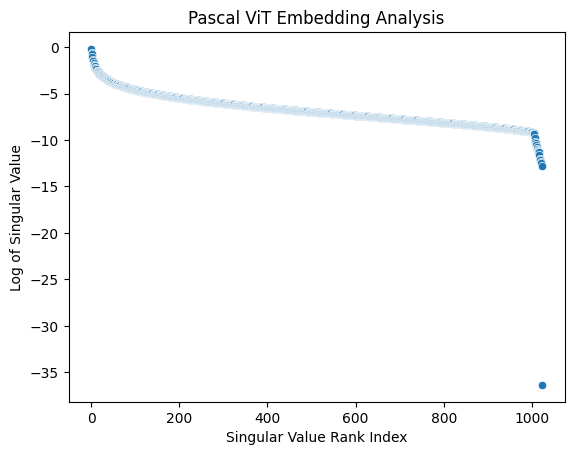

In [18]:
plot_singular_vals(pascal_embeddings, 'Pascal ViT Embedding Analysis')

# CIFAR 10

In [19]:
cifar10_emb_path = os.path.join(
        os.path.abspath(data_dir),
        'cifar10' + "_" + 'ViT' + "_train_embeddings.pkl",
    )
if os.path.exists(cifar10_emb_path):
    cifar10_embeddings = load_embeddings(cifar10_emb_path)
else:
    fullset = torchvision.datasets.CIFAR10(
    root=data_dir, train=True, download=True, transform=None
    )
    validation_set_fraction = 0.1
    num_fulltrn = len(fullset)
    num_val = int(num_fulltrn * validation_set_fraction)
    num_trn = num_fulltrn - num_val
    trainset, valset = random_split(
        fullset, [num_trn, num_val], generator=torch.Generator().manual_seed(seed)
    )

    images = [x[0] for x in trainset]
    cifar10_embeddings = compute_vit_image_embeddings(images, device, return_tensor=False)
    store_embeddings(cifar10_emb_path
        ,
        cifar10_embeddings,
    )

Distance Matrix construction time  0.3059382438659668


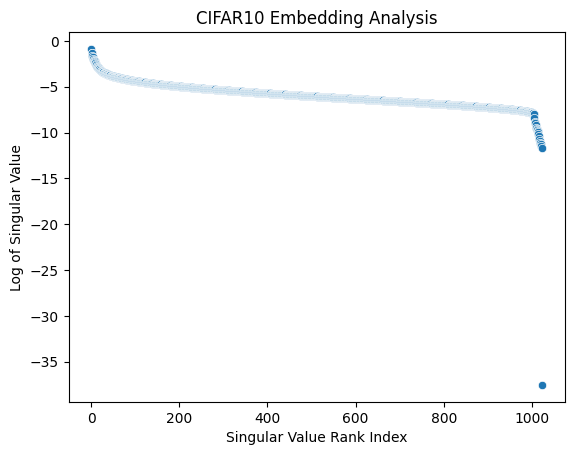

In [20]:
cifar10_sim_kernel = generate_similarity_matrix(pascal_embeddings, metric='cossim')
plot_singular_vals(cifar10_embeddings, 'CIFAR10 Embedding Analysis')

# CIFAR 100

In [21]:
cifar100_emb_path = os.path.join(
        os.path.abspath(data_dir),
        'cifar100' + "_" + 'ViT' + "_train_embeddings.pkl",
    )
if os.path.exists(cifar100_emb_path):
    cifar100_embeddings = load_embeddings(cifar100_emb_path)
else:
    fullset = torchvision.datasets.CIFAR100(
    root=data_dir, train=True, download=True, transform=None
    )
    validation_set_fraction = 0.1
    num_fulltrn = len(fullset)
    num_val = int(num_fulltrn * validation_set_fraction)
    num_trn = num_fulltrn - num_val
    trainset, valset = random_split(
        fullset, [num_trn, num_val], generator=torch.Generator().manual_seed(seed)
    )
    
    images = [x[0] for x in trainset]
    cifar100_embeddings = compute_vit_image_embeddings(images, device, return_tensor=False)
    store_embeddings(cifar100_emb_path
        ,
        cifar100_embeddings,
    )

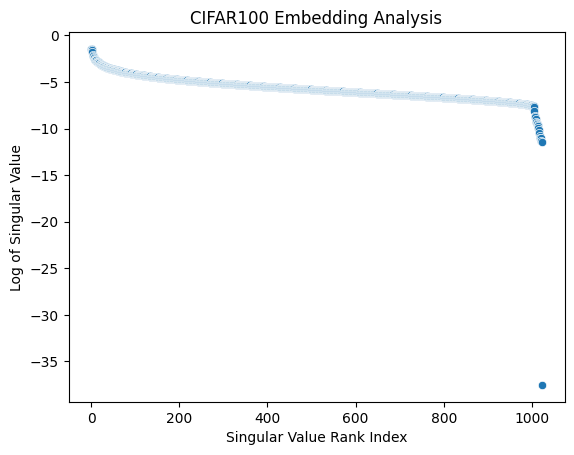

In [22]:
plot_singular_vals(cifar100_embeddings, 'CIFAR100 Embedding Analysis')

# Tiny ImageNet

In [23]:
def normalize_tin_val_folder_structure(path,
                                       images_folder='images',
                                       annotations_file='val_annotations.txt'):
    # Check if files/annotations are still there to see
    # if we already run reorganize the folder structure.
    images_folder = os.path.join(path, images_folder)
    annotations_file = os.path.join(path, annotations_file)

    # Exists
    if not os.path.exists(images_folder) \
       and not os.path.exists(annotations_file):
        if not os.listdir(path):
            raise RuntimeError('Validation folder is empty.')
        return

    # Parse the annotations
    with open(annotations_file) as f:
        for line in f:
            values = line.split()
            img = values[0]
            label = values[1]
            img_file = os.path.join(images_folder, values[0])
            label_folder = os.path.join(path, label)
            os.makedirs(label_folder, exist_ok=True)
            try:
                shutil.move(img_file, os.path.join(label_folder, img))
            except FileNotFoundError:
                continue

    os.sync()
    assert not os.listdir(images_folder)
    shutil.rmtree(images_folder)
    os.remove(annotations_file)
    os.sync()

In [24]:
class TinyImageNet(ImageFolder):
    """Dataset for TinyImageNet-200"""
    base_folder = 'tiny-imagenet-200'
    zip_md5 = '90528d7ca1a48142e341f4ef8d21d0de'
    splits = ('train', 'val')
    filename = 'tiny-imagenet-200.zip'
    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'

    def __init__(self, root, split='train', download=False, **kwargs):
        self.data_root = os.path.expanduser(root)
        self.split = verify_str_arg(split, "split", self.splits)

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')
        super().__init__(self.split_folder, **kwargs)

    @property
    def dataset_folder(self):
        return os.path.join(self.data_root, self.base_folder)

    @property
    def split_folder(self):
        return os.path.join(self.dataset_folder, self.split)

    def _check_exists(self):
        return os.path.exists(self.split_folder)

    def extra_repr(self):
        return "Split: {split}".format(**self.__dict__)

    def download(self):
        if self._check_exists():
            return
        download_and_extract_archive(
            self.url, self.data_root, filename=self.filename,
            remove_finished=True, md5=self.zip_md5)
        assert 'val' in self.splits
        normalize_tin_val_folder_structure(
            os.path.join(self.dataset_folder, 'val'))

In [25]:
def compute_vit_image_embeddings(images, device, return_tensor=False):
    feature_extractor = ViTFeatureExtractor.from_pretrained(
        "google/vit-large-patch16-224-in21k"
    )
    model = ViTModel.from_pretrained("google/vit-large-patch16-224-in21k")
    model = model.to(device)
    # inputs = feature_extractor(images, return_tensors="pt")
    sampler = BatchSampler(SequentialSampler(range(len(images))), 20, drop_last=False)
    img_features = []

    for indices in tqdm(sampler, total=len(sampler), desc='embedding'):
        if images[0].mode == "L":
            images_batch = [images[x].convert("RGB") for x in indices]
        else:
            images_batch = [images[x] for x in indices]
        batch_inputs = feature_extractor(images_batch, return_tensors="pt")
        tmp_feat_dict = {}
        for key in batch_inputs.keys():
            tmp_feat_dict[key] = batch_inputs[key].to(device=device)
        with torch.no_grad():
            batch_outputs = model(**tmp_feat_dict)
        batch_img_features = batch_outputs.last_hidden_state.mean(
            dim=1
        ).cpu()  # Averages over channels
        img_features.append(batch_img_features)
        del tmp_feat_dict

    img_features = torch.cat(img_features, dim=0)
    if return_tensor == False:
        return img_features.numpy()
    else:
        return img_features

In [26]:
tinyImageNet_emb_path = os.path.join(
        os.path.abspath(data_dir),
        'tinyImageNet' + "_" + 'ViT' + "_train_embeddings.pkl",
    )
if os.path.exists(tinyImageNet_emb_path):
    tinyImageNet_embeddings = load_embeddings(tinyImageNet_emb_path)
else:
    fullset = TinyImageNet(
    root=data_dir, split="train", download=True, transform=None
    )
    validation_set_fraction = 0.1
    num_fulltrn = len(fullset)
    num_val = int(num_fulltrn * validation_set_fraction)
    num_trn = num_fulltrn - num_val
    trainset, valset = random_split(
        fullset, [num_trn, num_val], generator=torch.Generator().manual_seed(seed)
    )
    
    images = [x[0] for x in trainset]
    print('here')
    tinyImageNet_embeddings = compute_vit_image_embeddings(images, device, return_tensor=False)
    store_embeddings(tinyImageNet_emb_path
        ,
        tinyImageNet_embeddings,
    )

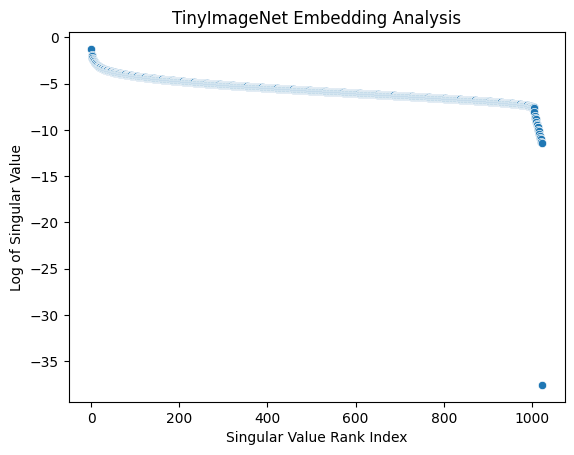

In [27]:
plot_singular_vals(tinyImageNet_embeddings, 'TinyImageNet Embedding Analysis')

# Pascal Segformer

In [28]:
pascal_sf_embeddings_path = '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/data/preprocessing/pascal_ctx_segformer_train_embeddings.pkl'
pascal_sf_embeddings = load_embeddings(pascal_sf_embeddings_path)

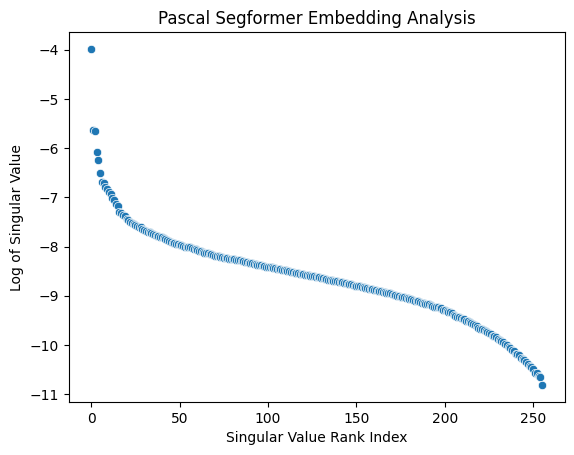

In [29]:
plot_singular_vals(pascal_sf_embeddings, 'Pascal Segformer Embedding Analysis')

# Pascal Oracle Spat

In [30]:
pascal_os_embeddings_path = '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/data/preprocessing/pascal_ctx_oracle_spat_train_embeddings.pkl'
pascal_os_embeddings = load_embeddings(pascal_os_embeddings_path)

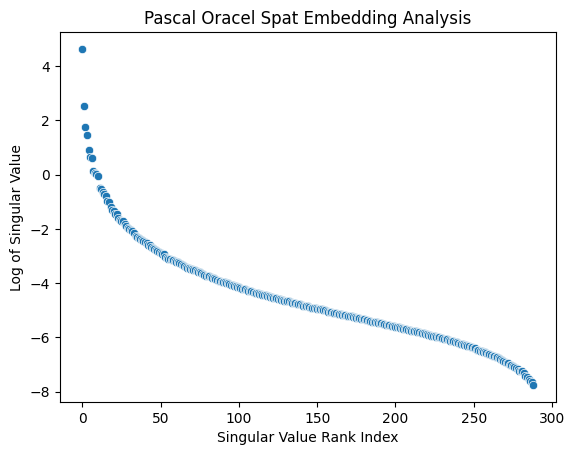

In [31]:
plot_singular_vals(pascal_os_embeddings, 'Pascal Oracel Spat Embedding Analysis')

# Pascal Oracle Context

In [32]:
pascal_oc_embeddings_path = '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/data/preprocessing/pascal_ctx_oracle_context_train_embeddings.pkl'
pascal_oc_embeddings = load_embeddings(pascal_oc_embeddings_path)

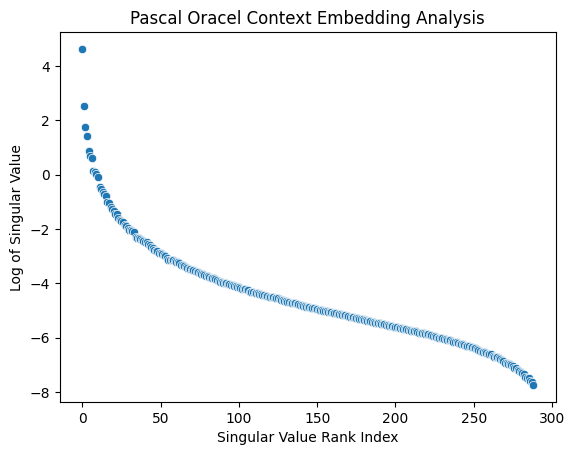

In [33]:
plot_singular_vals(pascal_oc_embeddings, 'Pascal Oracel Context Embedding Analysis')

In [46]:
log_sv_dict = {}
embeddings = zip([pascal_embeddings, pascal_oc_embeddings, pascal_os_embeddings, pascal_sf_embeddings], ['ViT', 'Oracle Context', 'Oracle Spatial', 'Segformer'])
for e, n in embeddings:
        if len(e.shape) == 3:
                emb = e.reshape((e.shape[0], e.shape[1]**2))
        else:
                emb = e
        cov = np.cov(emb, rowvar=False)
        U, s, V = np.linalg.svd(cov)
        log_sv_dict[n] = np.log(s)

# df = pd.DataFrame(log_sv_dict)
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in log_sv_dict.items() ]))


In [47]:
df

,ViT,Oracle Context,Oracle Spatial,Segformer
0,-0.203281,4.632683,4.633149,-3.983276
1,-0.652706,2.546085,2.546598,-5.626449
2,-0.745547,1.770797,1.740485,-5.646773
3,-1.114767,1.438845,1.453390,-6.075360
4,-1.383419,0.889686,0.923565,-6.245711
...,...,...,...,...
1019,-12.208715,NaN,NaN,NaN
1020,-12.336201,NaN,NaN,NaN
1021,-12.488504,NaN,NaN,NaN
1022,-12.809408,NaN,NaN,NaN


In [41]:
df.to_csv('/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/analysis/plot_csv/section_5/figure_5_4_3_1.csv')